In [6]:
import swarms
import pread as pd
from numpy import linspace, logspace, pi, array, exp
import matplotlib.pyplot as plt

In [7]:
RHO=1500
M0 = 10 * 7.34767309e22; Dt = 100.; Dmax = 250000.; L_s = 10 * 3.828e26;
M_s = 1.86 * 1.989e30; M_pl = 318 * 5.972e24; a_pl = 50 * 1.496e11
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = 10 * 3.086e16
argv = [M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr, d_pl]

In [45]:
t = 5e7
time = logspace(7.5, 10, 10)
waverange = logspace(-7, -3, 200)
lamb = 1.65e-6
a_plv = linspace(2 * 1.496e11, 80 * 1.496e11, 500)
type_star = "A"

In [46]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [47]:
def Finc(R_s, a_pl, F_star, f):
    return (f/4) * (R_s / a_pl)**2 * F_star 

In [48]:
def Fplt(B_nu_plt, R_plt, d_plt):
    return B_nu_plt * pi * R_plt ** 2 / d_plt ** 2

In [49]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
data = pd.Pread('data', 'Z002', 'pltlum_M318Z002.csv') 

In [50]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

In [51]:
def waverange_plt():
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    super_fplt_list = []
    for j in range(len(time)):
        fplt_list = []

        s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                            d_pl, correction=True, alpha=1./1.2)
        s.updateSwarm(time[j])
        T_star = s.stellarTemp()
        B_nu = s.computeBmu(waverange, T_star)
        F_star = Fstar(L_s, B_nu, T_star, d_pl)/1e-26

        for i in range(len(waverange)):
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                    a_pl, R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[j])

            index = data.find_time_index(time[j])
            if (index > -1):
                T_plt = lum_to_temp(data.lumin[index], data.radii[index])
                B_nu_plt = s2.computeBmu(waverange[i], T_plt)
                F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, d_pl)
                fplt_list.append(F_plt/1e-26)
                super_fplt_list.append(fplt_list)
                
    contrast_rat_plt = array(fplt_list) / F_star
    return contrast_rat_plt, super_fplt_list

In [52]:
def apl_plt():
    if type_star == "A":
        R_s = 1.7 * 6.955e08
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        R_s = 1 * 6.955e08
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        R_s = 0.32 * 6.955e08
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    fplt_list = []
    finc_plt_list = []
    
    s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1./1.2)
    s.updateSwarm(t)
    T_star = s.stellarTemp()
    print(T_star)
    B_nu = s.computeBmu(lamb, T_star)
    F_star = Fstar(L_s, B_nu, T_star, d_pl)/1e-26


    for i in range(len(a_plv)):
        s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                a_plv[i], R_pl, eta, Nstr, d_pl,
                                rho=RHO, fQ=5, f_vrel=4/pi,
                                correction=True, alpha=1.2)

        s2.updateSwarm(t)

        index = data.find_time_index(t)
        if (index > -1):
            T_plt = lum_to_temp(data.lumin[index], data.radii[index])
            B_nu_plt = s2.computeBmu(lamb, T_plt)
            F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, d_pl)
            F_inc = Finc(R_s, a_plv[i], F_star, 1.)
            fplt_list.append(F_plt/1e-26)
            finc_plt_list.append(F_inc)

    contrast_rat_plt = array(fplt_list) / F_star
    contrast_rat_inc_plt = array(finc_plt_list) / F_star
    print(T_plt)
    print("plt radii")
    print("{0:.3e}".format(data.radii[0]))
    print("plt lumin")
    print(data.lumin[0])
    print("fplt")
    print(fplt_list[0])
    print("no incident")
    print(contrast_rat_plt[0])
    print("incident only")
    print(contrast_rat_inc_plt[0])
    return (contrast_rat_plt+ contrast_rat_inc_plt)

In [53]:
contrast_wave_plt, super_flux_plt = waverange_plt()
contrast_apl_plt = apl_plt()
print("contrast")
print(contrast_apl_plt[0])

20000.0
377.99972713458607
plt radii
9.116e+07
plt lumin
4.709468854669795e+20
fplt
1.9350987638528268e-10
no incident
5.3978154229867146e-12
incident only
3.903992203641529e-06
contrast
3.9039976014569526e-06


C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)


In [54]:
f_vrel = 4/pi
Qd = s.computeQd(s.Dc)
part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
part2 = (M_pl/5.972e24)**0.06 * Qd**0.15 * eta
part3 = t * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

a_opt = 50 * part1 / part2 * part3**0.24 
print(a_opt)

NameError: name 's' is not defined

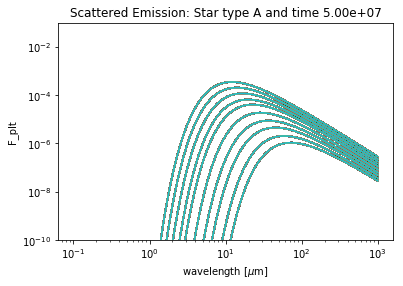

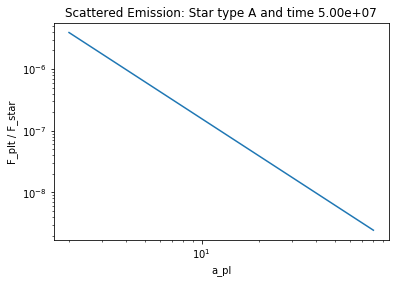

In [55]:
plt.figure(4)
for i in range(len(super_flux_plt)):
    plt.loglog(waverange*1e6, super_flux_plt[i])
plt.title("Scattered Emission: Star type "+str(type_star)+" and time {0:.2e}".format(t))
plt.xlabel(r"wavelength [$\mu$m]")
plt.ylabel("F_plt")
plt.ylim([10e-11, 10e-2])
plt.show()

plt.figure(5)
plt.loglog(a_plv/1.496e11, contrast_apl_plt)
plt.title("Scattered Emission: Star type "+str(type_star)+" and time {0:.2e}".format(t))
plt.xlabel("a_pl")
plt.ylabel("F_plt / F_star")
plt.show()